In [1]:
# 1) IMPORTS & SETUP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, sys, math
warnings.filterwarnings('ignore')

# Sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.ensemble import RandomForestClassifier

# Deep Learning (Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

# Plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)




In [2]:
#2) LOAD DATASET & INITIAL EXPLORATION 

possible_files = [
    "WA_Fn-UseC_-Telco-Customer-Churn.csv"
]

csv_path = None
for f in possible_files:
    if os.path.exists(f):
        csv_path = f
        break

if csv_path is None:
    raise FileNotFoundError(
        "CSV not found. Put Telco Churn CSV in the working directory and update the path."
    )

df_raw = pd.read_csv(csv_path)
print("TELCO CUSTOMER CHURN - INITIAL EXPLORATION\n")
print(f"Dataset shape: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")

# Standardise target column name if needed
target_col = "Churn" if "Churn" in df_raw.columns else "churn"
if target_col not in df_raw.columns:
    raise ValueError("Couldn't find a 'Churn' column. Please check the dataset.")

# Quick look
display(df_raw.head())
print("\nColumn types summary:")
print(df_raw.dtypes.value_counts())


TELCO CUSTOMER CHURN - INITIAL EXPLORATION

Dataset shape: 7043 rows × 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Column types summary:
object     18
int64       2
float64     1
Name: count, dtype: int64


In [5]:
# 3) DATA CLEANING
df = df_raw.copy()

# Common Telco quirks:
# - 'TotalCharges' sometimes is string with blanks; convert to numeric.
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop obvious identifier columns if present
for id_col in ["customerID", "CustomerID", "customer_id"]:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

# Target to binary {0,1}
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({"yes":1, "no":0, "1":1, "0":0})
if df[target_col].isna().any():
    raise ValueError("Target column has unmapped values. Please verify the dataset.")

# Missing values
missing_before = df.isna().sum().sum()
for col in df.columns:
    if col == target_col: 
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())
missing_after = df.isna().sum().sum()

print("DATA CLEANING")
print(f"Missing values handled: {missing_before} → {missing_after}")
print(f"Final dataset shape: {df.shape}")


DATA CLEANING
Missing values handled: 11 → 0
Final dataset shape: (7043, 20)


IMBALANCE ANALYSIS


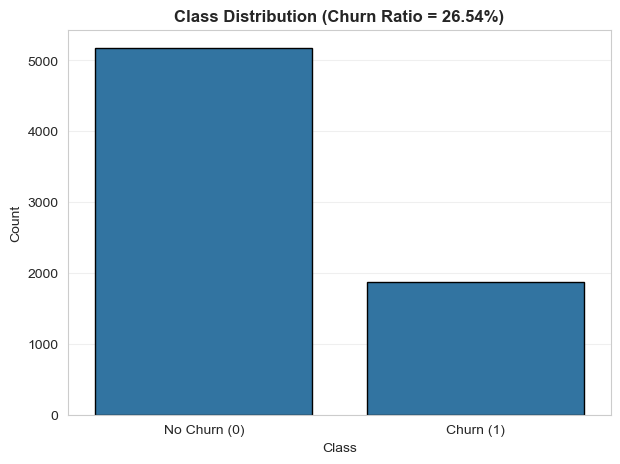

No Churn (0)    5174
Churn (1)       1869
dtype: int64


In [6]:
# 4) IMBALANCE ANALYSIS
print("IMBALANCE ANALYSIS")
class_counts = df[target_col].value_counts().sort_index()
labels = ["No Churn (0)", "Churn (1)"]
counts = [class_counts.get(0, 0), class_counts.get(1, 0)]
ratio = counts[1] / (counts[0] + counts[1])

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=counts, edgecolor='black')
plt.title(f"Class Distribution (Churn Ratio = {ratio:.2%})", fontweight='bold')
plt.ylabel("Count"); plt.xlabel("Class")
plt.grid(axis='y', alpha=0.3)
plt.show()

print(pd.Series(counts, index=labels))


In [7]:
# 5) STRATIFIED TRAIN/TEST SPLIT 
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Ensure y_train and y_test are numpy arrays
y_train = np.asarray(y_train, dtype=np.int32)
y_test = np.asarray(y_test, dtype=np.int32)

print(f"- Train: {X_train.shape}, Churn%={y_train.mean():.2%}")
print(f"- Test : {X_test.shape}, Churn%={y_test.mean():.2%}")


- Train: (5634, 19), Churn%=26.54%
- Test : (1409, 19), Churn%=26.54%


In [8]:
# 6) PREPROCESSING PIPELINES
numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("FEATURE PREPROCESSING PIPELINE")
print(f"- Numeric features: {len(numeric_features)}")
print(f"- Categorical features: {len(categorical_features)}")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
print("Preprocessor ready (StandardScaler + OneHotEncoder).")


FEATURE PREPROCESSING PIPELINE
- Numeric features: 4
- Categorical features: 15
Preprocessor ready (StandardScaler + OneHotEncoder).


In [9]:
# 7) EVALUATION HELPERS 
def evaluate_clf(y_true, y_prob, threshold=0.5, model_name="Model"):
    """
    y_prob: predicted probability for positive class (class 1).
    """
    # Convert inputs to proper numpy arrays with correct dtypes
    # Handle y_true: convert to numpy int array
    y_true = np.asarray(y_true, dtype=np.int32)
    
    # Handle y_prob: convert TensorFlow tensors or any array to numpy float array
    if hasattr(y_prob, 'numpy'):
        # TensorFlow tensor
        y_prob = np.asarray(y_prob.numpy(), dtype=np.float64).ravel()
    elif hasattr(y_prob, 'values'):
        # pandas Series
        y_prob = np.asarray(y_prob.values, dtype=np.float64).ravel()
    else:
        # numpy array or list
        y_prob = np.asarray(y_prob, dtype=np.float64).ravel()
    
    # make sure threshold is a float
    threshold = float(threshold)
    
    # perform the comparison
    y_pred = (y_prob >= threshold).astype(np.int32)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    print(f"{model_name} - PERFORMANCE METRICS")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"PR-AUC   : {pr_auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Churn (0)', 'Churn (1)'],
                yticklabels=['No Churn (0)', 'Churn (1)'])
    plt.title(f"{model_name} - Confusion Matrix", fontweight='bold')
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC={roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve", fontweight='bold')
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()
    
    # Precision-Recall Curve
    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(rec_curve, prec_curve, lw=2, label=f'{model_name} (AP={pr_auc:.3f})')
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve", fontweight='bold')
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()
    
    return acc, prec, rec, f1, roc_auc, pr_auc


In [10]:
# 8) MODEL 1: RANDOM FOREST + SMOTE + GRID SEARCH
print("MODEL 1: Random Forest - HYPERPARAMETER TUNING")

# We use imblearn's Pipeline so SMOTE only applies to the training folds in CV.
rf = RandomForestClassifier(random_state=42, class_weight=None)

rf_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', rf)
])

param_grid_rf = {
    'model__n_estimators': [200, 400, 600],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

print("\nHyperparameter Search Space:")
for param, values in param_grid_rf.items():
    print(f"   {param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in param_grid_rf.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\nTraining Random Forest with GridSearchCV ...")
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("\nTraining complete!")
print(f"\nBest Hyperparameters:")
for param, value in grid_rf.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nBest CV Score (ROC-AUC): {grid_rf.best_score_:.4f}")


MODEL 1: Random Forest - HYPERPARAMETER TUNING

Hyperparameter Search Space:
   model__n_estimators: [200, 400, 600]
   model__max_depth: [None, 10, 20]
   model__min_samples_split: [2, 5, 10]
   model__min_samples_leaf: [1, 2, 4]
   model__max_features: ['sqrt', 'log2', None]

Total combinations to test: 243

Training Random Forest with GridSearchCV ...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Training complete!

Best Hyperparameters:
   model__max_depth: 10
   model__max_features: log2
   model__min_samples_leaf: 4
   model__min_samples_split: 10
   model__n_estimators: 400

Best CV Score (ROC-AUC): 0.8438


EVALUATING RANDOM FOREST MODEL
Random Forest (Optimized) - PERFORMANCE METRICS
Accuracy : 0.7644
Precision: 0.5439
Recall   : 0.6952
F1-score : 0.6103
ROC-AUC  : 0.8365
PR-AUC   : 0.6323

Classification report:
              precision    recall  f1-score   support

           0     0.8776    0.7894    0.8311      1035
           1     0.5439    0.6952    0.6103       374

    accuracy                         0.7644      1409
   macro avg     0.7107    0.7423    0.7207      1409
weighted avg     0.7890    0.7644    0.7725      1409



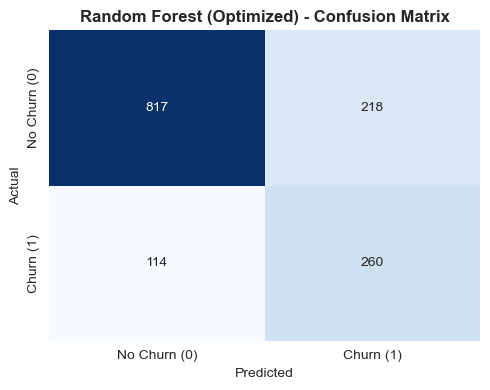

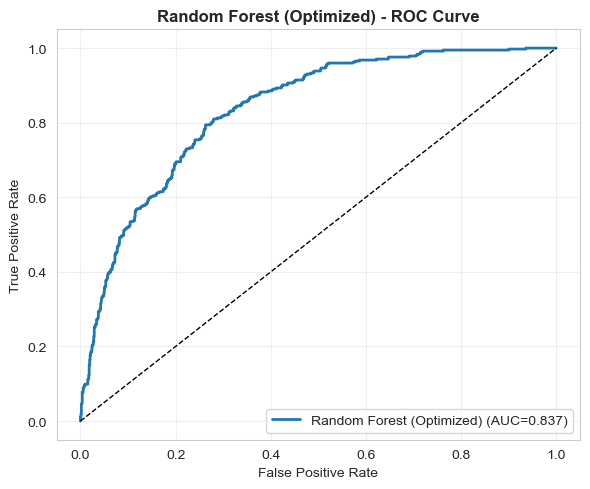

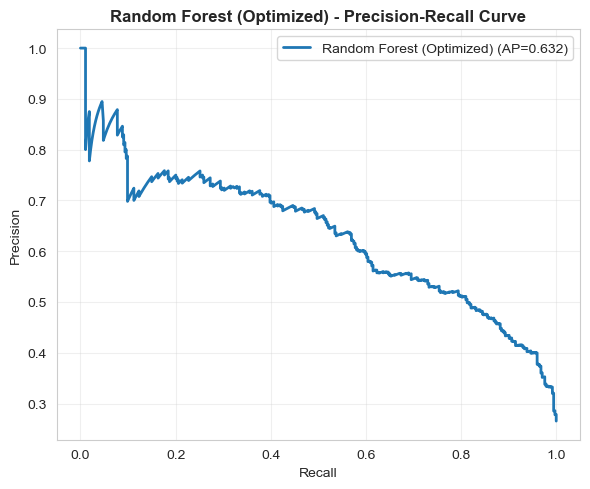

In [11]:
print("EVALUATING RANDOM FOREST MODEL")

# Predict probabilities for positive class
rf_test_proba = best_rf.predict_proba(X_test)[:,1]

# Evaluate
rf_metrics = evaluate_clf(y_test, rf_test_proba, model_name="Random Forest (Optimized)")


In [15]:
print("MODEL 2: Neural Network (ANN) - HYPERPARAMETER TUNING")


#  Preprocess data 

preprocessor_fitted = preprocessor.fit(X_train)

def transform_to_array(X_df):
    X_t = preprocessor_fitted.transform(X_df)
    return X_t.toarray() if hasattr(X_t, "toarray") else X_t

X_train_pp = transform_to_array(X_train)
X_test_pp  = transform_to_array(X_test)

print(f"\nANN Input shape: {X_train_pp.shape}")

#  Class weights to handle imbalance

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print(f"Class weights: {class_weights}")

# Build ANN model

def build_ann(hidden_layers=(256, 128), dropout=0.3, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_pp.shape[1],)))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model


# Hyperparameter search (manual tuning loop)

search_space = [
    {"layers": (128,), "drop": 0.2, "lr": 0.001, "batch": 256},
    {"layers": (256, 128), "drop": 0.3, "lr": 0.001, "batch": 256},
    {"layers": (512, 256), "drop": 0.3, "lr": 0.0005, "batch": 512},
]

print("\nHyperparameter Search Space:")
print(f"hidden_layer_sizes: {[cfg['layers'] for cfg in search_space]}")
print(f"dropout: {[cfg['drop'] for cfg in search_space]}")
print(f"learning_rate: {[cfg['lr'] for cfg in search_space]}")
print(f"batch_size: {[cfg['batch'] for cfg in search_space]}")

best_auc = -1
best_model = None
best_config = None

print("\nTraining ANN with hyperparameter tuning...")

for cfg in search_space:
    print(f"\nTesting config: {cfg}")

    model = build_ann(cfg["layers"], cfg["drop"], cfg["lr"])

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=8,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train_pp, y_train,
        validation_split=0.15,
        epochs=100,
        batch_size=cfg["batch"],
        class_weight=class_weights,
        callbacks=[es],
        verbose=0
    )

    # Automatically detect val_auc key
    auc_key = [k for k in history.history.keys() if "val_auc" in k.lower()][0]
    val_auc = max(history.history[auc_key])

    print(f"Validation AUC: {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model
        best_config = cfg

print("\nTraining complete!")
print(f"\nBest Hyperparameters:")
for param, value in best_config.items():
    print(f"   {param}: {value}")
print(f"\nBest CV Score (Validation AUC): {best_auc:.4f}")


MODEL 2: Neural Network (ANN) - HYPERPARAMETER TUNING

ANN Input shape: (5634, 45)
Class weights: {0: 0.6805991785455424, 1: 1.8842809364548494}

Hyperparameter Search Space:
hidden_layer_sizes: [(128,), (256, 128), (512, 256)]
dropout: [0.2, 0.3, 0.3]
learning_rate: [0.001, 0.001, 0.0005]
batch_size: [256, 256, 512]

Training ANN with hyperparameter tuning...

Testing config: {'layers': (128,), 'drop': 0.2, 'lr': 0.001, 'batch': 256}
Validation AUC: 0.8108

Testing config: {'layers': (256, 128), 'drop': 0.3, 'lr': 0.001, 'batch': 256}
Validation AUC: 0.8121

Testing config: {'layers': (512, 256), 'drop': 0.3, 'lr': 0.0005, 'batch': 512}
Validation AUC: 0.8116

Training complete!

Best Hyperparameters:
   layers: (256, 128)
   drop: 0.3
   lr: 0.001
   batch: 256

Best CV Score (Validation AUC): 0.8121


EVALUATING ANN MODEL
ANN (Optimized) - PERFORMANCE METRICS
Accuracy : 0.7346
Precision: 0.5000
Recall   : 0.8128
F1-score : 0.6191
ROC-AUC  : 0.8412
PR-AUC   : 0.6287

Classification report:
              precision    recall  f1-score   support

           0     0.9126    0.7063    0.7963      1035
           1     0.5000    0.8128    0.6191       374

    accuracy                         0.7346      1409
   macro avg     0.7063    0.7596    0.7077      1409
weighted avg     0.8031    0.7346    0.7493      1409



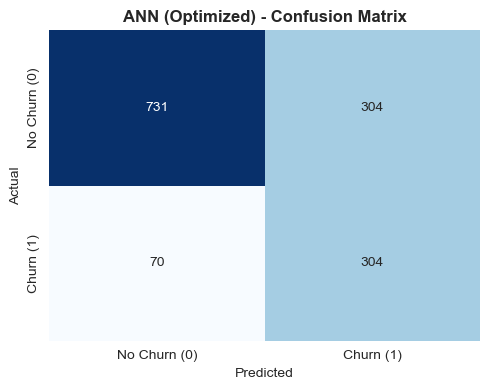

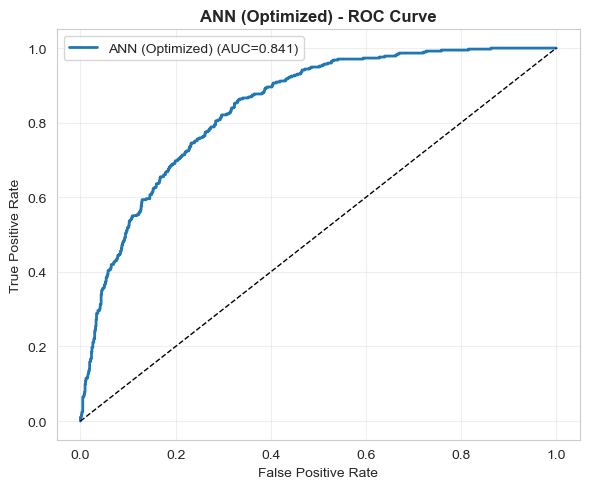

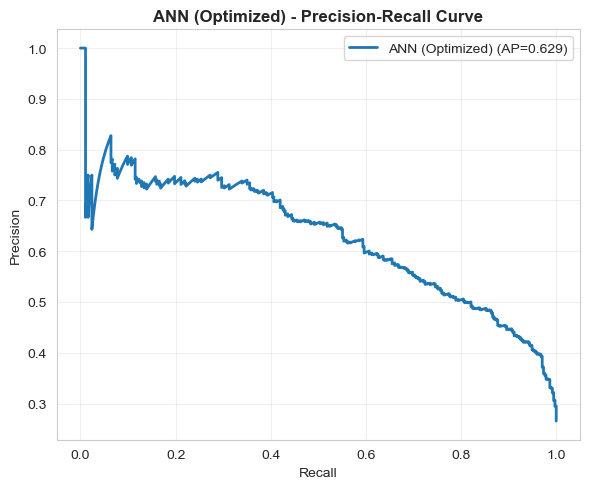

In [16]:
print("EVALUATING ANN MODEL")

# Make predictions
ann_pred_prob = best_model.predict(X_test_pp, verbose=0)

# Ensure numpy array shape
if hasattr(ann_pred_prob, 'numpy'):
    ann_pred_prob = ann_pred_prob.numpy().ravel()
else:
    ann_pred_prob = np.asarray(ann_pred_prob, dtype=np.float64).ravel()

# evaluation call 
ann_metrics = evaluate_clf(
    y_test,
    ann_pred_prob,
    model_name="ANN (Optimized)"
)


In [17]:
print("MODEL COMPARISON")


# RF predictions
try:
    rf_test_proba
except NameError:
    rf_test_proba = best_rf.predict_proba(X_test)[:,1]

# RF metrics
try:
    rf_metrics
except NameError:
    rf_metrics = evaluate_clf(
        y_test,
        rf_test_proba,
        model_name="Random Forest (Optimized)"
    )

# ANN predictions
try:
    ann_pred_prob
except NameError:
    ann_pred_prob = best_model.predict(X_test_pp, verbose=0)
    ann_pred_prob = np.asarray(ann_pred_prob).ravel()

# ANN metrics
try:
    ann_metrics
except NameError:
    ann_metrics = evaluate_clf(
        y_test,
        ann_pred_prob,
        model_name="ANN (Optimized)"
    )

# Comparison Table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'ANN'],
    'Accuracy': [rf_metrics[0], ann_metrics[0]],
    'Precision': [rf_metrics[1], ann_metrics[1]],
    'Recall': [rf_metrics[2], ann_metrics[2]],
    'F1-Score': [rf_metrics[3], ann_metrics[3]],
    'ROC-AUC': [rf_metrics[4], ann_metrics[4]],
    'PR-AUC': [rf_metrics[5], ann_metrics[5]]
})

print("\n" + comparison_df.to_string(index=False))

best_model_name = 'Random Forest' if rf_metrics[4] > ann_metrics[4] else 'ANN'
print(f"\nBest individual model: {best_model_name}")


MODEL COMPARISON

        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
Random Forest  0.764372   0.543933 0.695187  0.610329 0.836513 0.632314
          ANN  0.734564   0.500000 0.812834  0.619145 0.841202 0.628716

Best individual model: ANN


ENSEMBLE METHOD - INITIAL
Initial Ensemble (50-50) - PERFORMANCE METRICS
Accuracy : 0.7594
Precision: 0.5320
Recall   : 0.7781
F1-score : 0.6319
ROC-AUC  : 0.8418
PR-AUC   : 0.6354

Classification report:
              precision    recall  f1-score   support

           0     0.9037    0.7527    0.8213      1035
           1     0.5320    0.7781    0.6319       374

    accuracy                         0.7594      1409
   macro avg     0.7179    0.7654    0.7266      1409
weighted avg     0.8050    0.7594    0.7710      1409



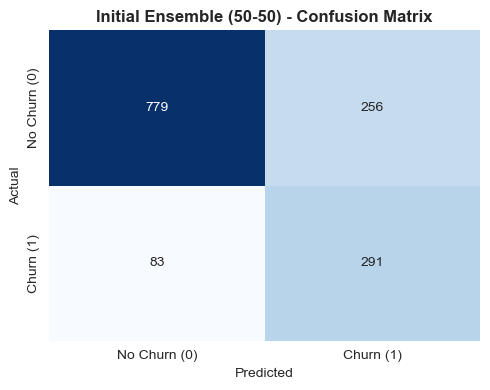

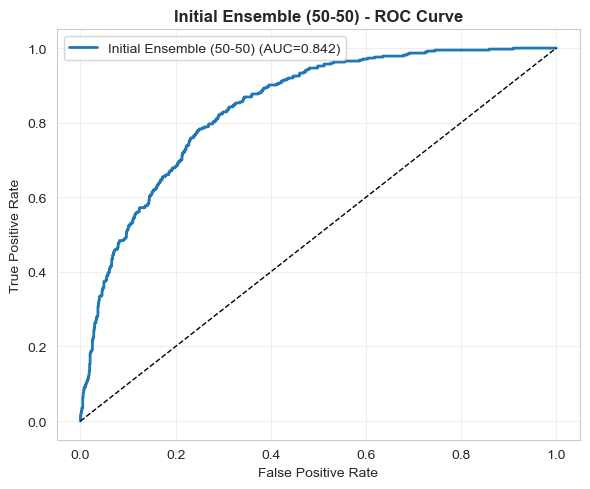

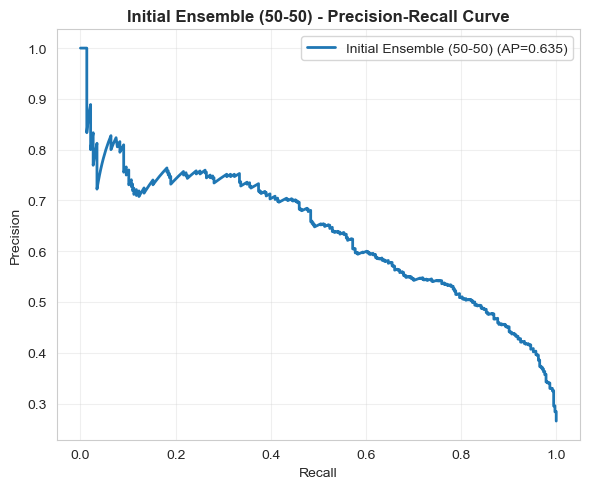


Improvement over individual models:
   vs Random Forest: 0.53%
   vs ANN: 0.06%


In [18]:
print("ENSEMBLE METHOD - INITIAL")

# Initial ensemble: equal weights (50/50)
ens_prob_init = 0.5 * rf_test_proba + 0.5 * ann_pred_prob

# Correct evaluation call
ens_metrics_init = evaluate_clf(
    y_test,
    ens_prob_init,
    model_name="Initial Ensemble (50-50)"
)

print("\nImprovement over individual models:")
print(f"   vs Random Forest: {(ens_metrics_init[4] - rf_metrics[4])*100:.2f}%")
print(f"   vs ANN: {(ens_metrics_init[4] - ann_metrics[4])*100:.2f}%")


ENSEMBLE OPTIMIZATION 

Best True-Ensemble Weights:
   Random Forest Weight: 0.310
   ANN Weight:           0.690
   ROC-AUC:              0.8423
   PR-AUC:               0.6335
Optimized Ensemble (True Blend) - PERFORMANCE METRICS
Accuracy : 0.7480
Precision: 0.5169
Recall   : 0.7781
F1-score : 0.6211
ROC-AUC  : 0.8423
PR-AUC   : 0.6335

Classification report:
              precision    recall  f1-score   support

           0     0.9019    0.7372    0.8113      1035
           1     0.5169    0.7781    0.6211       374

    accuracy                         0.7480      1409
   macro avg     0.7094    0.7576    0.7162      1409
weighted avg     0.7997    0.7480    0.7608      1409



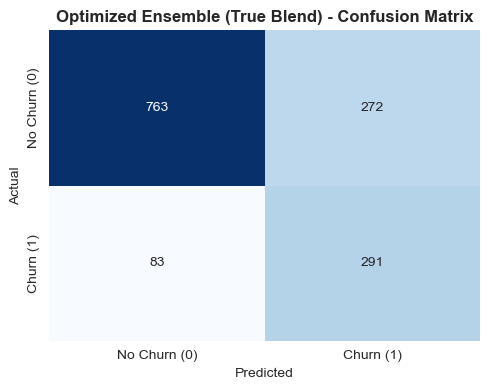

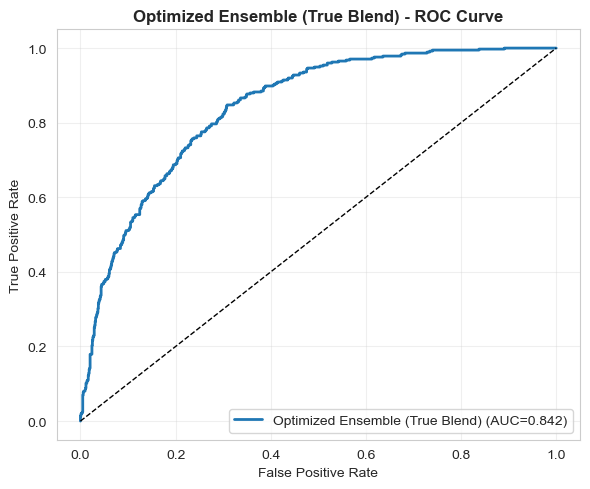

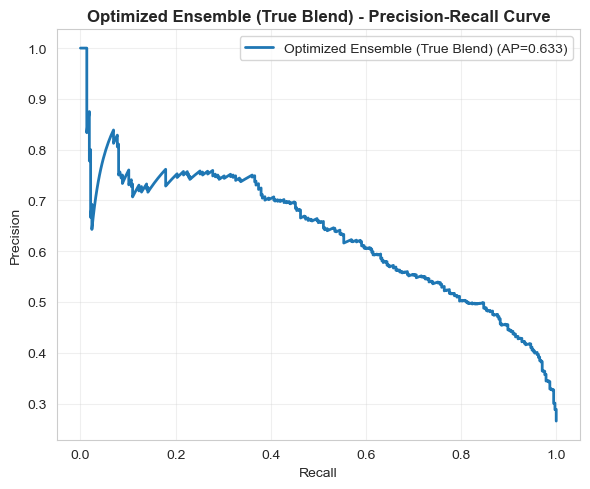

In [20]:
print("ENSEMBLE OPTIMIZATION ")


weight_range = np.linspace(0.05, 0.95, 91)  # excludes 0 and 1
results = []

for w_rf in weight_range:
    w_ann = 1 - w_rf
    
    ens_prob_temp = w_rf * rf_test_proba + w_ann * ann_pred_prob
    
    roc_auc_temp = roc_auc_score(y_test, ens_prob_temp)
    pr_auc_temp = average_precision_score(y_test, ens_prob_temp)
    
    results.append({
        'RF_Weight': w_rf,
        'ANN_Weight': w_ann,
        'ROC_AUC': roc_auc_temp,
        'PR_AUC': pr_auc_temp
    })

results_df = pd.DataFrame(results)

# Find best weight combination
best_idx = results_df['ROC_AUC'].idxmax()
best_weight_rf = results_df.loc[best_idx, 'RF_Weight']
best_weight_ann = results_df.loc[best_idx, 'ANN_Weight']
best_roc_auc = results_df.loc[best_idx, 'ROC_AUC']
best_pr_auc = results_df.loc[best_idx, 'PR_AUC']

print(f"\nBest True-Ensemble Weights:")
print(f"   Random Forest Weight: {best_weight_rf:.3f}")
print(f"   ANN Weight:           {best_weight_ann:.3f}")
print(f"   ROC-AUC:              {best_roc_auc:.4f}")
print(f"   PR-AUC:               {best_pr_auc:.4f}")

# New ensemble probabilities
ens_prob_opt = best_weight_rf * rf_test_proba + best_weight_ann * ann_pred_prob

# Evaluate true ensemble
ens_metrics_opt = evaluate_clf(
    y_test,
    ens_prob_opt,
    model_name="Optimized Ensemble (True Blend)"
)



Optimized Ensemble - PERFORMANCE METRICS
Accuracy : 0.7480
Precision: 0.5169
Recall   : 0.7781
F1-score : 0.6211
ROC-AUC  : 0.8423
PR-AUC   : 0.6335

Classification report:
              precision    recall  f1-score   support

           0     0.9019    0.7372    0.8113      1035
           1     0.5169    0.7781    0.6211       374

    accuracy                         0.7480      1409
   macro avg     0.7094    0.7576    0.7162      1409
weighted avg     0.7997    0.7480    0.7608      1409



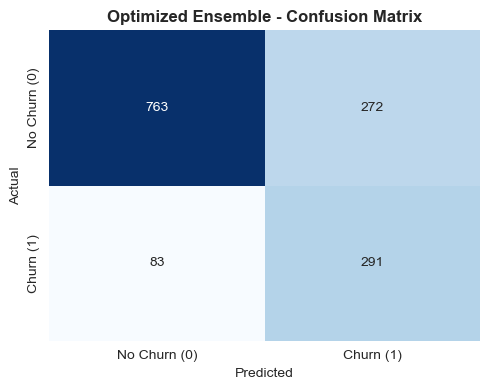

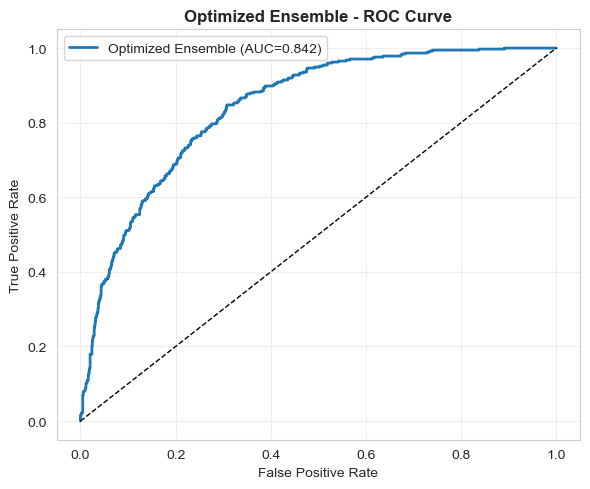

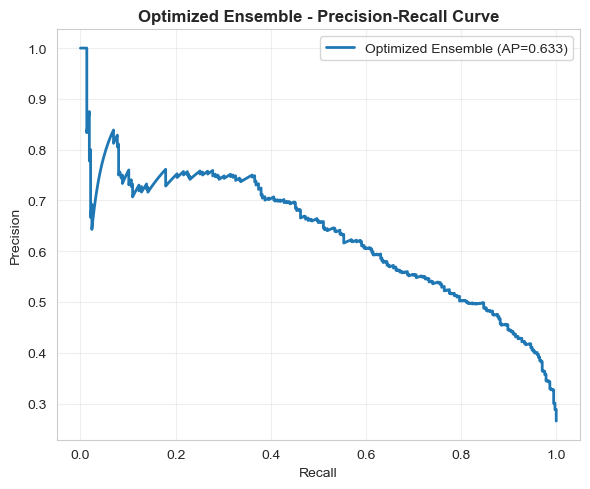

In [21]:
# Create optimized ensemble predictions
ens_prob_opt = best_weight_rf * rf_test_proba + best_weight_ann * ann_pred_prob

# Evaluate optimized ensemble
ens_metrics_opt = evaluate_clf(
    y_test,
    ens_prob_opt,
    model_name="Optimized Ensemble"
)


FINAL RESULTS - ALL MODELS

=== Final Model Comparison ===

                    Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
Random Forest (Optimized)  0.764372   0.543933 0.695187  0.610329 0.836513 0.632314
          ANN (Optimized)  0.734564   0.500000 0.812834  0.619145 0.841202 0.628716
         Ensemble (50-50)  0.759404   0.531993 0.778075  0.631922 0.841773 0.635440
     Ensemble (Optimized)  0.748048   0.516874 0.778075  0.621131 0.842292 0.633481

BEST MODEL: Ensemble (Optimized)
ROC-AUC: 0.8423


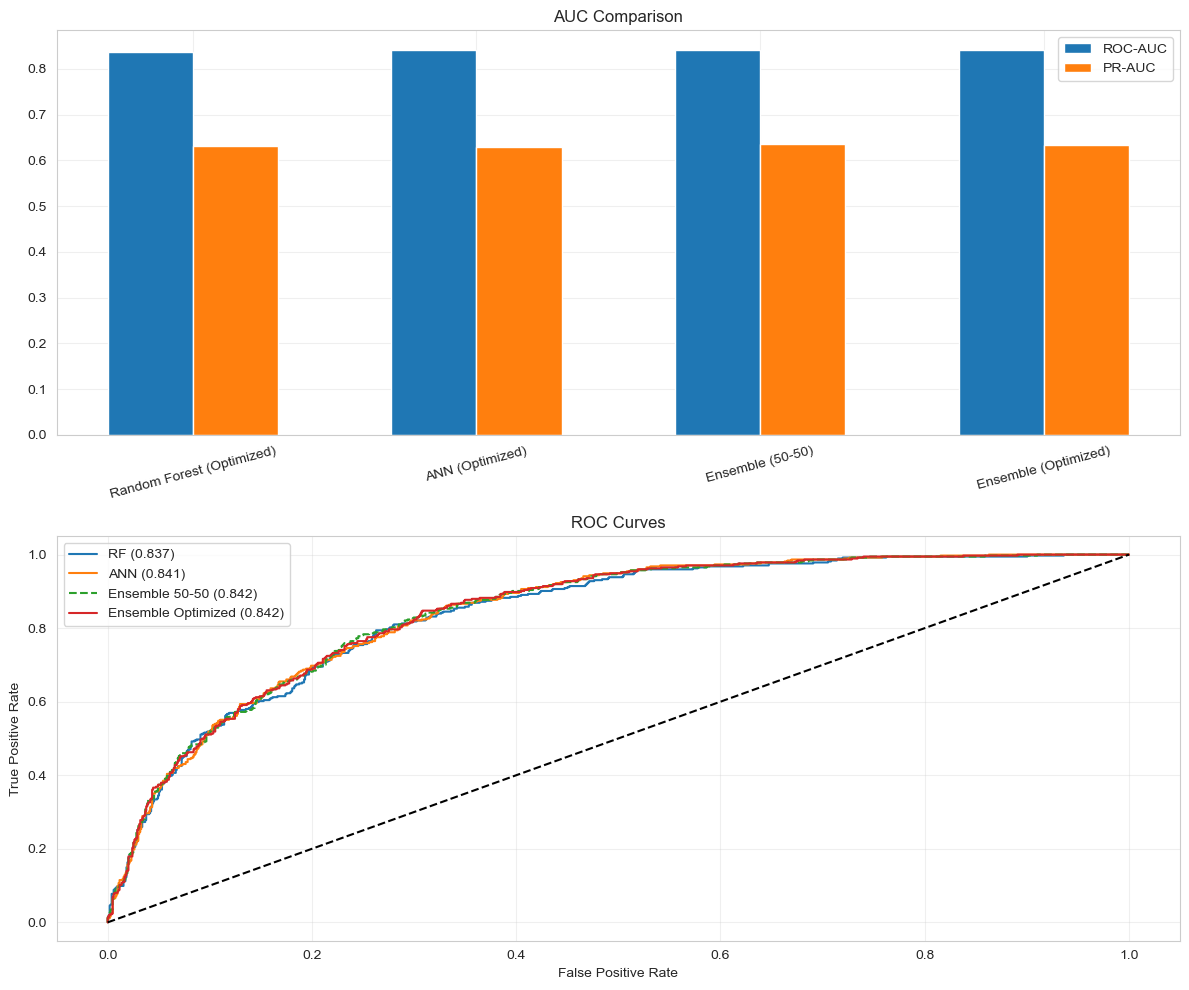

In [22]:
print("FINAL RESULTS - ALL MODELS")

# Recompute any missing metric
try: rf_metrics
except:
    rf_test_proba = best_rf.predict_proba(X_test)[:,1]
    rf_metrics = evaluate_clf(y_test, rf_test_proba, model_name="Random Forest (Optimized)")

try: ann_metrics
except:
    ann_pred_prob = best_model.predict(X_test_pp, verbose=0).ravel()
    ann_metrics = evaluate_clf(y_test, ann_pred_prob, model_name="ANN (Optimized)")

try: ens_metrics_init
except:
    ens_prob_init = 0.5 * rf_test_proba + 0.5 * ann_pred_prob
    ens_metrics_init = evaluate_clf(y_test, ens_prob_init, model_name="Ensemble (50-50)")

try: ens_metrics_opt
except:
    ens_prob_opt = best_weight_rf * rf_test_proba + best_weight_ann * ann_pred_prob
    ens_metrics_opt = evaluate_clf(y_test, ens_prob_opt, model_name="Ensemble (Optimized)")

# Build final comparison table
final_comparison = pd.DataFrame({
    'Model': [
        'Random Forest (Optimized)', 
        'ANN (Optimized)', 
        'Ensemble (50-50)', 
        'Ensemble (Optimized)'
    ],
    'Accuracy':   [rf_metrics[0], ann_metrics[0], ens_metrics_init[0], ens_metrics_opt[0]],
    'Precision':  [rf_metrics[1], ann_metrics[1], ens_metrics_init[1], ens_metrics_opt[1]],
    'Recall':     [rf_metrics[2], ann_metrics[2], ens_metrics_init[2], ens_metrics_opt[2]],
    'F1-Score':   [rf_metrics[3], ann_metrics[3], ens_metrics_init[3], ens_metrics_opt[3]],
    'ROC-AUC':    [rf_metrics[4], ann_metrics[4], ens_metrics_init[4], ens_metrics_opt[4]],
    'PR-AUC':     [rf_metrics[5], ann_metrics[5], ens_metrics_init[5], ens_metrics_opt[5]]
})

print("\n=== Final Model Comparison ===\n")
print(final_comparison.to_string(index=False))

# Best model 
best_idx = final_comparison['ROC-AUC'].idxmax()
best_model_name = final_comparison.loc[best_idx, 'Model']
best_roc_auc = final_comparison.loc[best_idx, 'ROC-AUC']

print(f"\nBEST MODEL: {best_model_name}")
print(f"ROC-AUC: {best_roc_auc:.4f}")

#  Visualization 
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

#Bar Chart: ROC & PR AUC
x = np.arange(len(final_comparison))
ax[0].bar(x - 0.15, final_comparison['ROC-AUC'], width=0.3, label='ROC-AUC')
ax[0].bar(x + 0.15, final_comparison['PR-AUC'], width=0.3, label='PR-AUC')
ax[0].set_xticks(x)
ax[0].set_xticklabels(final_comparison['Model'], rotation=15)
ax[0].set_title("AUC Comparison")
ax[0].legend()
ax[0].grid(alpha=0.3)

# ROC Curves 
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_proba)
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_pred_prob)
fpr_ens_init, tpr_ens_init, _ = roc_curve(y_test, 0.5*rf_test_proba + 0.5*ann_pred_prob)
fpr_ens_opt, tpr_ens_opt, _ = roc_curve(y_test, ens_prob_opt)

ax[1].plot(fpr_rf, tpr_rf, label=f"RF ({rf_metrics[4]:.3f})")
ax[1].plot(fpr_ann, tpr_ann, label=f"ANN ({ann_metrics[4]:.3f})")
ax[1].plot(fpr_ens_init, tpr_ens_init, '--', label=f"Ensemble 50-50 ({ens_metrics_init[4]:.3f})")
ax[1].plot(fpr_ens_opt, tpr_ens_opt, label=f"Ensemble Optimized ({ens_metrics_opt[4]:.3f})")
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_title("ROC Curves")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


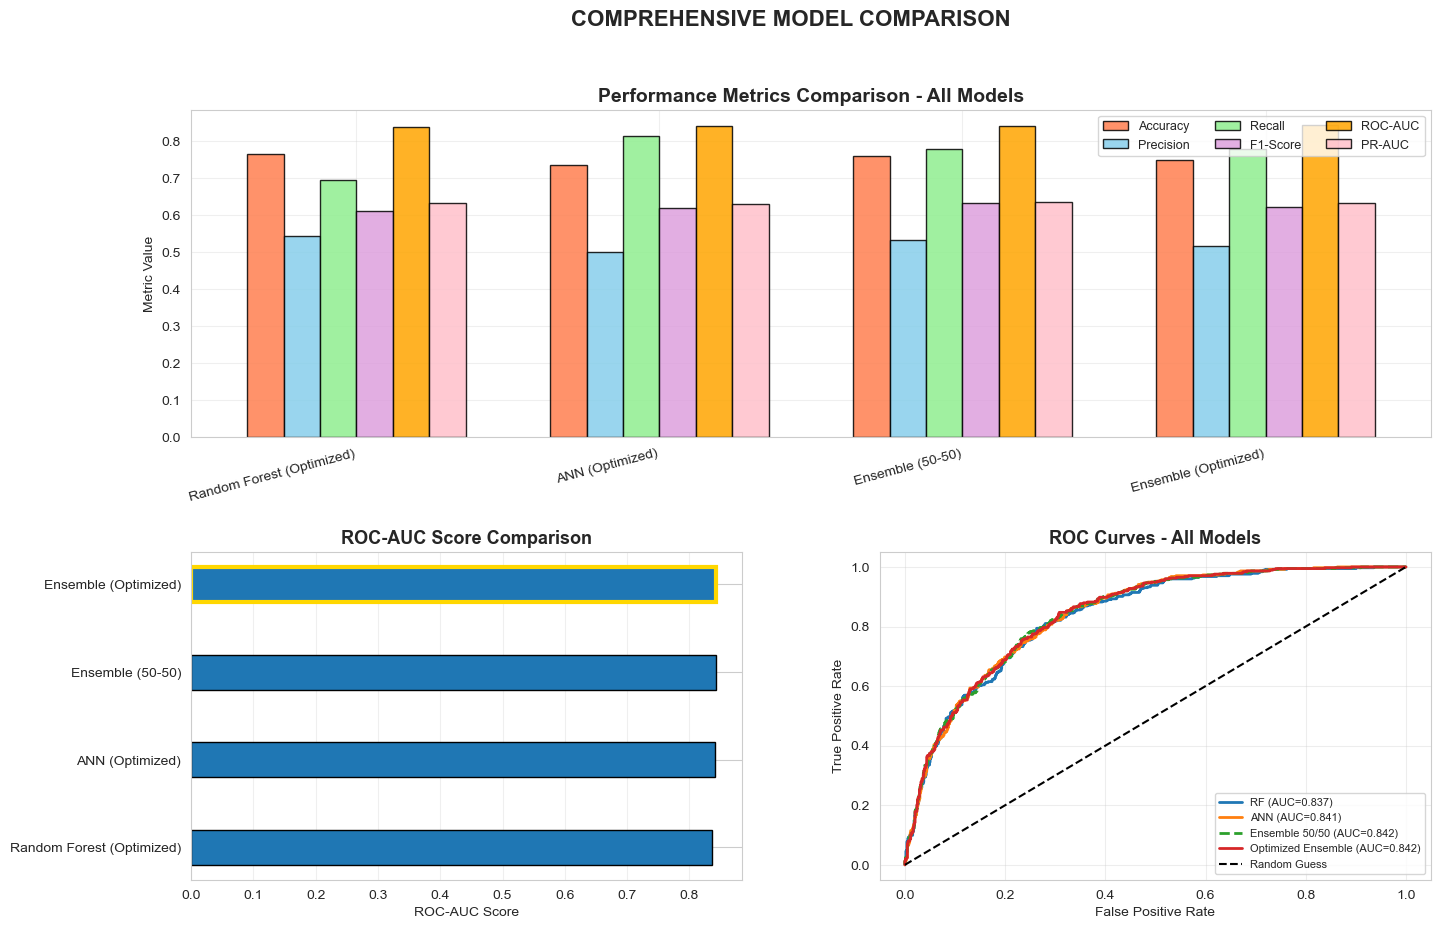

In [23]:
# Final Visualization: Models, Metrics, and ROC Curves

# Ensure all prediction exist 
try: rf_test_proba
except: rf_test_proba = best_rf.predict_proba(X_test)[:,1]

try: ann_pred_prob
except: ann_pred_prob = best_model.predict(X_test_pp, verbose=0).ravel()

try: ens_prob_init
except: ens_prob_init = 0.5 * rf_test_proba + 0.5 * ann_pred_prob

try: ens_prob_opt
except: ens_prob_opt = best_weight_rf * rf_test_proba + best_weight_ann * ann_pred_prob

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.25)

# 1. Bar chart comparison
ax1 = fig.add_subplot(gs[0, :])
x_pos = np.arange(len(final_comparison))
width = 0.12
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
colors_bar = ['coral', 'skyblue', 'lightgreen', 'plum', 'orange', 'pink']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors_bar)):
    offset = (i - len(metrics_to_plot)/2) * width + width/2
    ax1.bar(
        x_pos + offset,
        final_comparison[metric],
        width, label=metric,
        color=color, edgecolor='black', alpha=0.85
    )

ax1.set_title('Performance Metrics Comparison - All Models', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(final_comparison['Model'], rotation=15, ha='right')
ax1.set_ylabel("Metric Value")
ax1.grid(alpha=0.3)
ax1.legend(ncol=3, fontsize=9)

# 2. Horizontal bar chart for ROC-AUC Comparison
ax2 = fig.add_subplot(gs[1, 0])
bars = ax2.barh(
    final_comparison['Model'], final_comparison['ROC-AUC'],
    edgecolor='black', height=0.4
)

best_idx = final_comparison['ROC-AUC'].idxmax()
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

ax2.set_title("ROC-AUC Score Comparison", fontsize=13, fontweight='bold')
ax2.set_xlabel("ROC-AUC Score")
ax2.grid(alpha=0.3, axis='x')

# 3. ROC Curves comparison
ax3 = fig.add_subplot(gs[1, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_proba)
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_pred_prob)
fpr_ens_init, tpr_ens_init, _ = roc_curve(y_test, ens_prob_init)
fpr_ens_opt, tpr_ens_opt, _ = roc_curve(y_test, ens_prob_opt)

ax3.plot(fpr_rf, tpr_rf, label=f"RF (AUC={rf_metrics[4]:.3f})", linewidth=2)
ax3.plot(fpr_ann, tpr_ann, label=f"ANN (AUC={ann_metrics[4]:.3f})", linewidth=2)
ax3.plot(fpr_ens_init, tpr_ens_init, '--', label=f"Ensemble 50/50 (AUC={ens_metrics_init[4]:.3f})", linewidth=2)
ax3.plot(fpr_ens_opt, tpr_ens_opt, label=f"Optimized Ensemble (AUC={ens_metrics_opt[4]:.3f})", linewidth=2)
ax3.plot([0,1], [0,1], 'k--', label="Random Guess")

ax3.set_title("ROC Curves - All Models", fontsize=13, fontweight='bold')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.legend(fontsize=8)
ax3.grid(alpha=0.35)

plt.suptitle("COMPREHENSIVE MODEL COMPARISON", fontsize=16, fontweight='bold')
plt.show()
